In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pomegranate import *
from pomegranate import BayesianNetwork
import time
%matplotlib inline
df = pd.read_csv('claims.csv')
df.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [2]:
df.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

In [3]:
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
obj_df = df.select_dtypes(include=['object']).copy()
for i in obj_df.columns:
    df[i] = ord_enc.fit_transform(df[[i]])
    
int_df = df.select_dtypes(include=['int64']).copy()
for i in int_df.columns:
    df[i] = df[i].astype(float)

In [4]:
df.nunique()

Month                      12
WeekOfMonth                 5
DayOfWeek                   7
Make                       19
AccidentArea                2
DayOfWeekClaimed            8
MonthClaimed               13
WeekOfMonthClaimed          5
Sex                         2
MaritalStatus               4
Age                        66
Fault                       2
PolicyType                  9
VehicleCategory             3
VehiclePrice                6
FraudFound_P                2
PolicyNumber            15420
RepNumber                  16
Deductible                  4
DriverRating                4
Days_Policy_Accident        5
Days_Policy_Claim           4
PastNumberOfClaims          4
AgeOfVehicle                8
AgeOfPolicyHolder           9
PoliceReportFiled           2
WitnessPresent              2
AgentType                   2
NumberOfSuppliments         4
AddressChange_Claim         5
NumberOfCars                5
Year                        3
BasePolicy                  3
dtype: int

In [5]:
df.drop(columns = ['PolicyNumber','Age'],inplace=True)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(df.copy(), test_size=0.3, random_state=42)

In [7]:
Features = ['AgeOFPolicyHolder','Fault','AccidentArea','AgeOfVehicle','PastNumberOfClaims','NumberOfCars','VehiclePrice','AddressChange_Claim','BasePolicy','Make','AdressChange_Claim','VehicleCategory','Deductible']

In [8]:
Remove = []
for i in list(df.columns):
    if i not in Features and i!='FraudFound_P':
        Remove.append(i)
    
Remove

['Month',
 'WeekOfMonth',
 'DayOfWeek',
 'DayOfWeekClaimed',
 'MonthClaimed',
 'WeekOfMonthClaimed',
 'Sex',
 'MaritalStatus',
 'PolicyType',
 'RepNumber',
 'DriverRating',
 'Days_Policy_Accident',
 'Days_Policy_Claim',
 'AgeOfPolicyHolder',
 'PoliceReportFiled',
 'WitnessPresent',
 'AgentType',
 'NumberOfSuppliments',
 'Year']

In [9]:
X_train.drop(columns = Remove,inplace=True)

In [10]:
X_train.nunique()

Make                   19
AccidentArea            2
Fault                   2
VehicleCategory         3
VehiclePrice            6
FraudFound_P            2
Deductible              4
PastNumberOfClaims      4
AgeOfVehicle            8
AddressChange_Claim     5
NumberOfCars            5
BasePolicy              3
dtype: int64

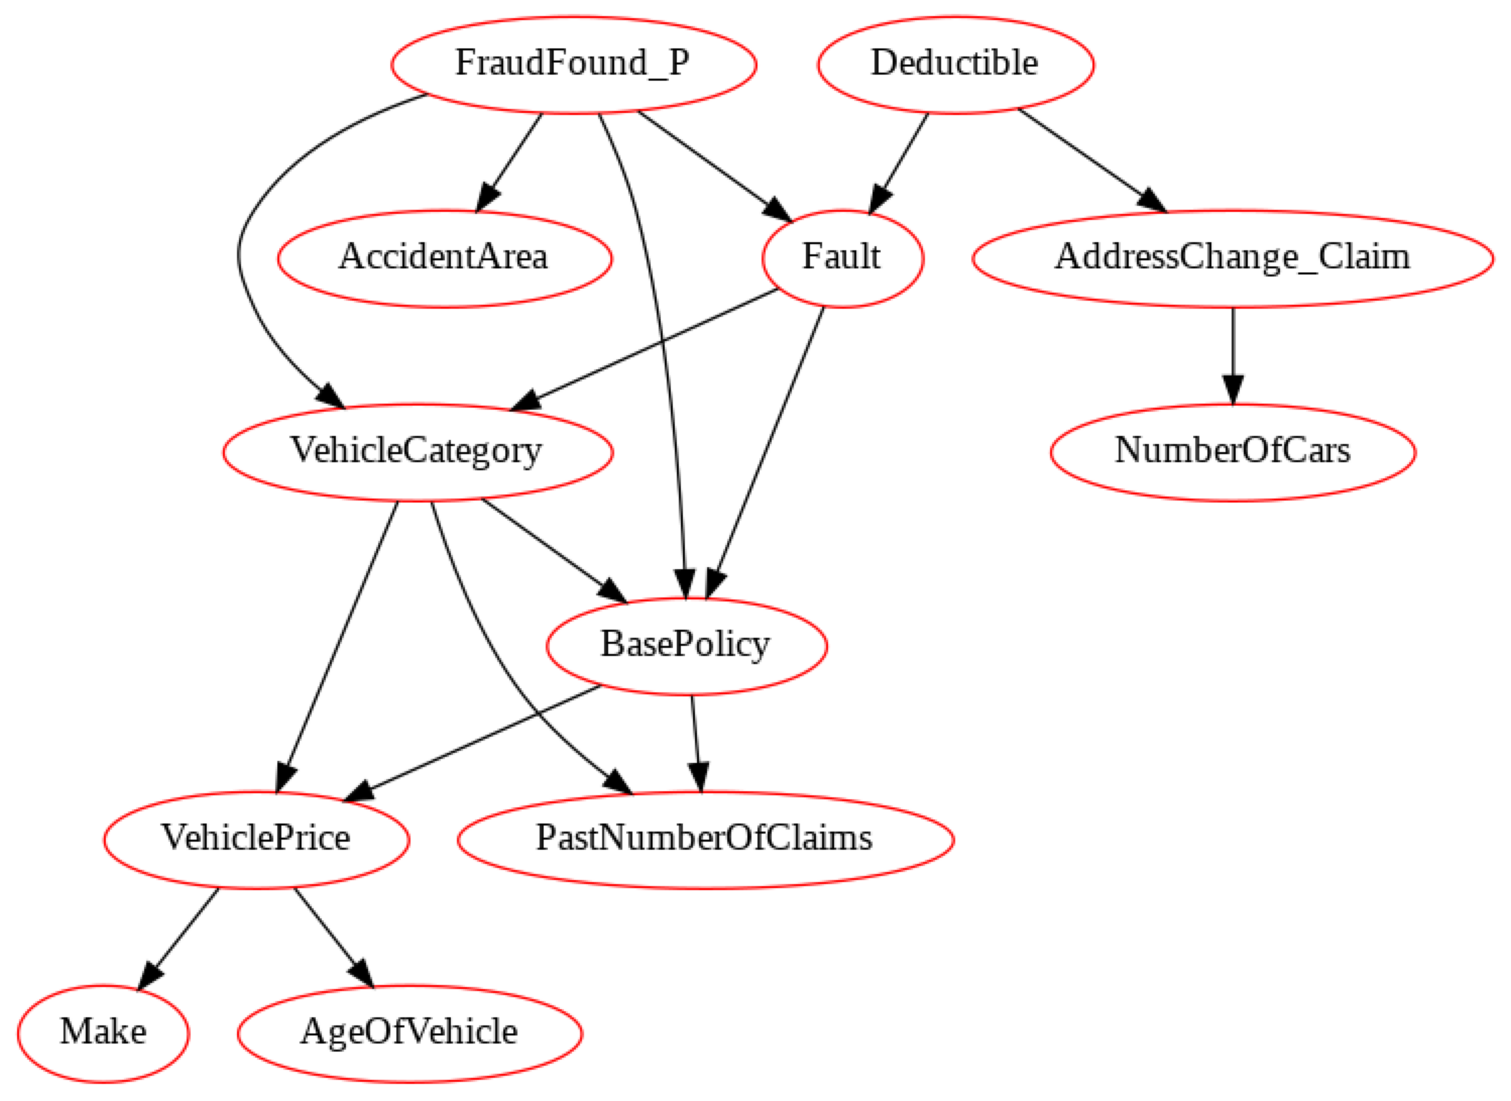

2.627929210662842


In [11]:

tic = time.time()
model_f = BayesianNetwork.from_samples(X_train.to_numpy(dtype=int),state_names=list(X_train.columns))
#model_f = BayesianNetwork.from_samples(X_train.to_numpy(dtype=int),state_names=list(X_train.columns),algorithm='chow-liu',root=5)
tac = time.time()
plt.figure(figsize=(28, 20))
model_f.plot()
plt.show()
print(tac-tic)

In [12]:
X_test.drop(columns = Remove,inplace=True)
d  = dict(zip(list(X_train.columns),X_test.to_numpy(dtype=int)[1,:]))
d.pop('FraudFound_P')
c = model_f.predict_proba(d)
y = X_test['FraudFound_P'].copy()

In [13]:
y_hat = np.zeros(len(y))
for i in range(len(X_test)):
  d  = dict(zip(list(X_train.columns),X_test.to_numpy(dtype=int)[i,:]))
  d.pop('FraudFound_P')
  c = model_f.predict_proba(d)
  y_hat[i] = c[5].parameters[0][0]


S2: 82.38084845839546 %


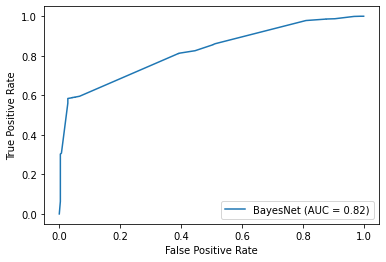

In [14]:
import seaborn as sns
from sklearn import metrics
print("S2:",metrics.roc_auc_score(np.ones(len(y))-y,y_hat)*100,'%')

fpr_bn, tpr_bn, thresholds = metrics.roc_curve(np.ones(len(y))-y,y_hat)
roc_auc = metrics.auc(fpr_bn, tpr_bn)
display = metrics.RocCurveDisplay(fpr=fpr_bn, tpr=tpr_bn, roc_auc=roc_auc,estimator_name='BayesNet')
display.plot()  
plt.savefig('chow.png')
plt.show()  


# Naive Bayes

In [15]:
y_train = X_train['FraudFound_P'].copy()
y_test = X_test['FraudFound_P'].copy()

In [16]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB(class_prior=[.94, .06])
tic = time.time()
clf.fit(X_train.drop(columns='FraudFound_P'), y_train)
tac = time.time()
print(tac-tic)

0.009995698928833008


In [17]:
y_pred = clf.predict_proba(X_test.drop(columns='FraudFound_P'))[:,1]
from sklearn import metrics
print("S2:",metrics.roc_auc_score(y_test,y_pred)*100,'%')

S2: 75.30361263675198 %


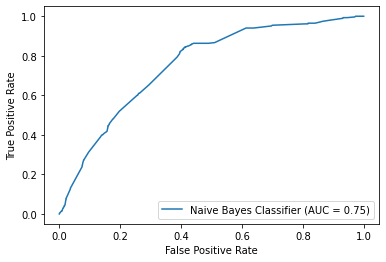

In [18]:
fpr_NB, tpr_NB, thresholds = metrics.roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr_NB, tpr_NB)
display = metrics.RocCurveDisplay(fpr=fpr_NB, tpr=tpr_NB, roc_auc=roc_auc,estimator_name='Naive Bayes Classifier')
display.plot()  
plt.savefig('AUC.png')

# ANN

In [19]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(40,20), random_state=1)
tic = time.time()
clf.fit(X_train.drop(columns='FraudFound_P'), y_train)
tac = time.time()
print(tac-tic)

1.8307955265045166


In [20]:
y_pred = clf.predict_proba(X_test.drop(columns='FraudFound_P'))[:,1]
print("S2:",metrics.roc_auc_score(y_test,y_pred)*100,'%')

S2: 77.36571329267653 %


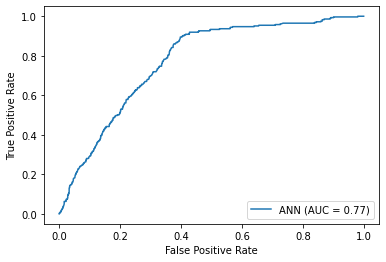

In [21]:
fpr_NN, tpr_NN, thresholds = metrics.roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr_NN, tpr_NN)
display = metrics.RocCurveDisplay(fpr=fpr_NN, tpr=tpr_NN, roc_auc=roc_auc,estimator_name='ANN')
display.plot()  
plt.savefig('AUC.png')

# RF

S2: 74.27834155764901 %
0.6295444965362549


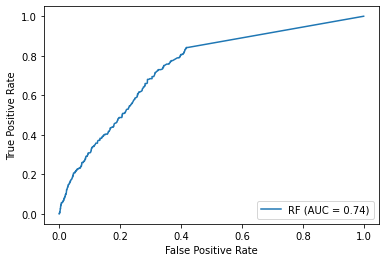

In [22]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
tic = time.time()
clf.fit(X_train.drop(columns='FraudFound_P'), y_train)
tac = time.time()
y_pred = clf.predict_proba(X_test.drop(columns='FraudFound_P'))[:,1]
print("S2:",metrics.roc_auc_score(y_test,y_pred)*100,'%')
fpr_RF, tpr_RF, thresholds = metrics.roc_curve(y_test,y_pred)
roc_auc = metrics.auc(fpr_RF, tpr_RF)
display = metrics.RocCurveDisplay(fpr=fpr_RF, tpr=tpr_RF, roc_auc=roc_auc,estimator_name='RF')
display.plot()  
plt.savefig('AUC.png')
print(tac-tic)

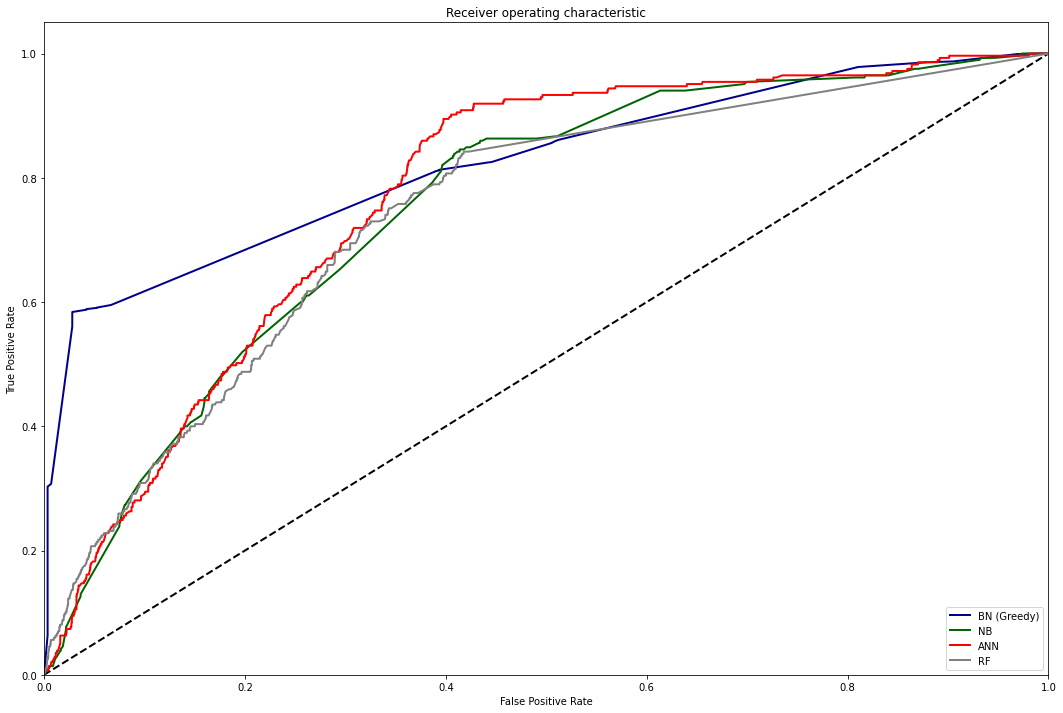

In [24]:
plt.figure(figsize=(18,12))
lw = 2
plt.plot(fpr_bn, tpr_bn, color='darkblue',
         lw=lw, label='BN (Greedy)' % roc_auc)
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='BN (Chow-Liu)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
plt.plot(fpr_NB, tpr_NB, color='darkgreen',
         lw=lw, label='NB' % roc_auc)
plt.plot(fpr_NN, tpr_NN, color='red',
         lw=lw, label='ANN' % roc_auc)
plt.plot(fpr_RF, tpr_RF, color='grey',
         lw=lw, label='RF' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('All_auc.png')
plt.show()
